In [1]:
import os

def check_is_google_colab():
    return 'google.colab' in str(get_ipython())


def prepare_environment():
    if check_is_google_colab():
        from google.colab import drive
        import shutil
        
        drive.mount('/content/gdrive/')

        PATH_TO_TEMP_REPO = '/content/gdrive/My Drive/toxic-comments-repo-temp'

        try:
            shutil.rmtree(PATH_TO_TEMP_REPO)
        except:
            pass

        os.mkdir(PATH_TO_TEMP_REPO)
        
        %cd ./gdrive/My Drive/toxic-comments-repo-temp
        ! git clone https://github.com/nsbarsukov/toxic-comments-detector.git .
        ! pip3 install -q tensorflow_text navec fasttext
    else:
        %cd ..

prepare_environment()

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    evaluate_model,
    get_3d_quartile_words_count,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS
)

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


## Train model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers, losses

In [5]:
MAX_FEATURES = 10000
MAX_SEQUENCE_LENGTH = get_3d_quartile_words_count(X_train.flatten())

vectorize_layer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)
vectorize_layer.adapt(X_train)

In [6]:
model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    vectorize_layer,
    layers.Embedding(
        input_dim = len(vectorize_layer.get_vocabulary()),
        output_dim = 100
    ),
    layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [7]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION, # сколько от тестовой выборки отрезать под валидационную
)

Epoch 1/10
19/19 [==============================] - 2s 73ms/step - loss: 0.6829 - binary_accuracy: 0.6152 - recall: 0.1841 - precision: 0.3853 - val_loss: 0.6508 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 0s 20ms/step - loss: 0.6427 - binary_accuracy: 0.6616 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6145 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 0s 20ms/step - loss: 0.6023 - binary_accuracy: 0.6652 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5657 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 0s 19ms/step - loss: 0.5514 - binary_accuracy: 0.6647 - recall: 0.0194 - precision: 0.9675 - val_loss: 0.5128 - val_binary_accuracy: 0.7095 - val_recall: 0.1406 - val_precision: 0.9153
Epoch 5/10
1

# Model evaluation

Accuracy: 89.21%
Recall: 78.62%
Precision: 87.51%
F1-score: 82.83% 



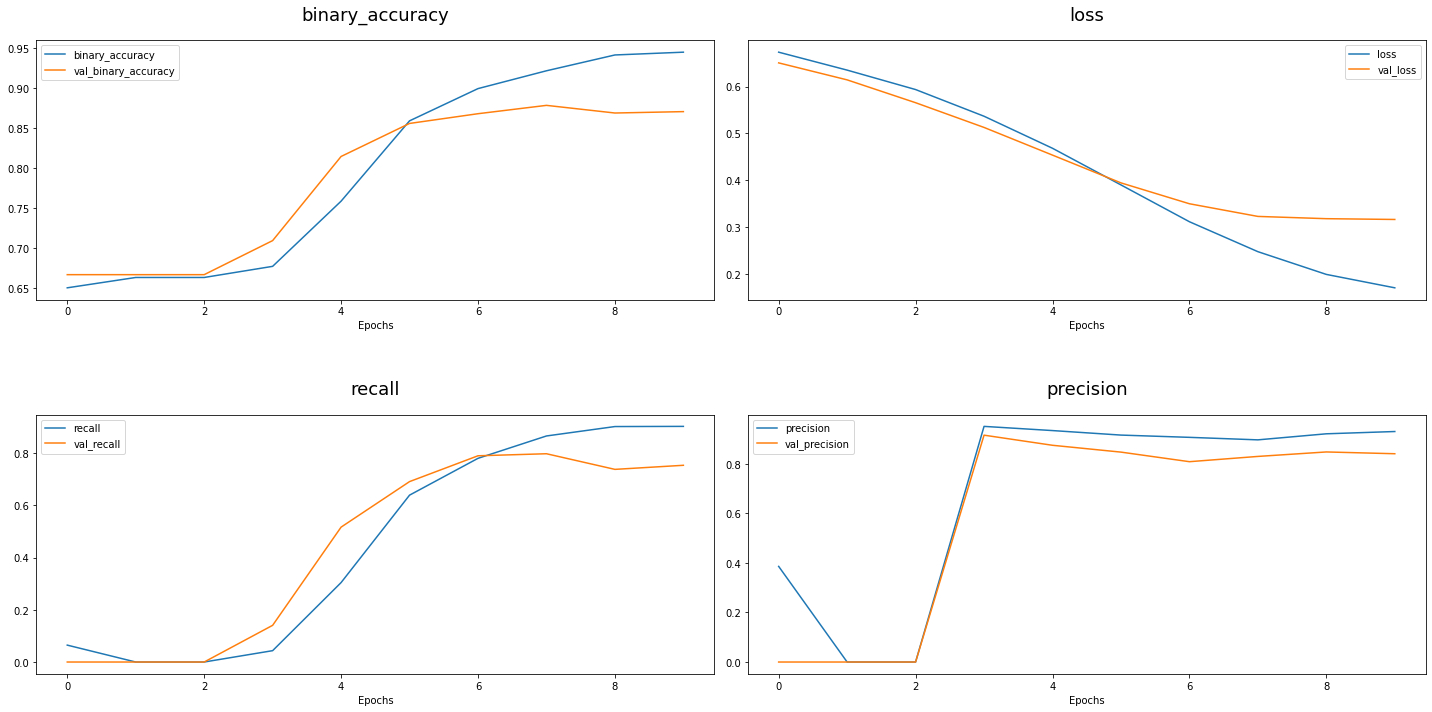

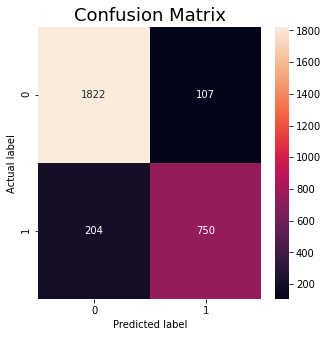

In [8]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)